<div hidden>
    $\newcommand{\q}{\left}$
    $\newcommand{\w}{\right}$
    $\newcommand{\m}{\middle}$
    $\newcommand{\e}{\boldsymbol}$
    $\newcommand{\cb}{\mspace{3mu}\m\vert\mspace{3mu}}$
</div>

<center>
    Sveučilište u Zagrebu<br>
    Fakultet elektrotehnike i računarstva<br>
    <a href="http://www.fer.unizg.hr/predmet/dubuce">Duboko učenje 2</a>
</center>

<h1>
    Laboratorijska vježba 2: <br> Varijacijski autoenkoder
</h1>

In [1]:
# automatsko 're-importanje' modula kada se nešto izmijeni
%load_ext autoreload
%autoreload 2

# podešavanje fonta i margina radi bolje čitkosti
from IPython.display import display, HTML, Math

display(HTML('<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Source Serif Pro">'))

with open("style.css", "r") as file:
    display(HTML("<style>" + file.read() + "</style>"))

In [2]:
import math

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

matplotlib.rcParams["figure.figsize"] = (6, 4.5)
matplotlib.rcParams["figure.dpi"] = 100
sns.set_context("notebook")

from graphics import plot_context

---

## Uvod

U strojnom učenju, <b>modeli s latentnim varijablama</b> su modeli koji uz <b>osmotrene</b> varijable (tipično označene sa $\e x$) uključuju i <b>neosmotrene</b> ili <b>latentne varijable</b> (tipično označene sa $\e z$).
U prošloj laboratorijskoj vježbi upoznali smo se s <b>modelom mješavine</b>
Gustoću vjerojatnosti podataka razložili smo pomoću <b>diskretne slučajne varijable</b> $\e z$ kao
\begin{equation}
  p_{\e \theta}\q(\e x\w) = \sum_{k=1}^K p_{\e \theta}\q(\e x \cb z_k\w) \cdot p_{\e \theta}\q(z_k\w),
\end{equation}
gdje je $\e z$ mogla poprimiti svega $K$ različitih vrijednosti, stoga se u formuli koristila <b>suma</b> po svim njenim realizacijama.
Razmotrimo sada situaciju kada bi $\e z$ bila neka <b>kontinuirana slučajna varijabla</b>.
Formula gustoće vjerojatnosti podataka bila bi
\begin{equation}
  p_{\e \theta}\q(\e x\w) = \int_{\mathcal Z} p_{\e \theta}\q(\e x \cb \e z\w) \cdot p_{\e \theta}\q(\e z\w) \, d\e z,
\end{equation}
gdje oznaka $\mathcal Z$ u integralu označava prostor vrijednosti koje slučajna varijabla $\e z$ može poprimiti.
Kako $\e z$ može poprimiti neprebrojivo mnogo vrijednosti, u gornjoj formuli koristi se integral po svim realizacijama slučajne varijable $\e z$.
Neovisno o tome je li $\e z$ diskretna ili kontinuirana, oba izraza možemo zapisati preko operatora očekivanja kao
\begin{equation}
  p_{\e \theta}\q(\e x\w) = \mathbb E_{\e z \sim p_{\e \theta}\q(\e z\w)} \q[p_{\e \theta} \q(\e x \cb \e z\w) \w].
\end{equation}

U nastavku vježbe radit ćemo s kontinuiranim latentnim varijablama.
To znači da za kompletan opis modela treba definirati:
 - vrstu distribucije varijable $\e z$,
 - parametre gustoće vjerojatnosti $p_{\e \theta}\q(\e z\w)$,
 - vrstu uvjetne distribucije varijable $\e x$ uz uvjet $\e z$, odnosno distribuciju $\q.\e x \cb \e z\w.$, i
 - parametre gustoće vjerojatnosti $p_{\e \theta}\q(\e x \cb \e z\w)$, odnosno funkcijsku ovisnost između uvjeta $\e z$ i parametara te gustoće vjerojatnosti.

Za opisivanje ovisnosti između realizacije slučajne varijable $\e z$ i parametara uvjetne distribucije $\q.\e x \cb \e z\w.$ ćemo koristiti <b>duboku neuronsku mrežu</b> (što nismo trebali u slučaju modela mješavine iz prošle vježbe).
Stoga se ovi modeli još nazivaju i <b>duboki modeli s latentnim varijablama</b> (engl. <i>deep latent variable models</i>, <i>DLVM</i>).

U prethodnoj laboratorijskoj vježbi određivali smo parametre distribucije koristeći kriterij maksimalne izglednosti.
Htjeli smo približno opisati neku nepoznatu gustoću vjerojatnosti $\mathcal p^*\q(\e x\w)$ za koju smo pretpostavili da je generirala skup podataka $\mathcal D = \q\{\e x^{(1)}, \e x^{(2)}, \ldots, \e x^{(N)}\w\}$, i to služeći se nekom parametriziranom familijom distribucija $\mathcal P\q(\e \theta\w)$.
Preciznije, tražili smo parametre gustoće vjerojatnosti $p_{\e \theta}\q(\e x\w)$ koji maksimiziraju log-izglednost pod pretpostavkom nezavisnosti i jednake distribuiranosti uzoraka:
\begin{equation}
  \log L\q(\e \theta \cb \mathcal D\w) = \sum_{i=1}^N \log p_{\e \theta}\q(\e x\w)
\end{equation}
Parametre smo tražili gradijentnim spustom, te nismo imali poteškoća s izračunom gradijenata.

No, u ovoj laboratorijskoj vježbi susrest ćemo se s novim problemima prilikom treniranja modela s kontinuiranom latentnom varijablom.
Prva prepreka će biti nemogućnost egzaktnog računanja integrala očekivanja $\mathbb E_{\e z \sim p_{\e \theta}\q(\e z\w)} \q[p_{\e \theta} \q(\e x \cb \e z\w) \w]$, zbog čega ćemo koristiti Monte Carlo metodu za <b>estimaciju očekivanja</b> (zadatak 2.).
No preduvjet za korištenje Monte Carlo metoda je generiranje <b>uzorka slučajne varijable</b> po zadanoj distribuciji (zadatak 1.).
Zatim ćemo vidjeti da pažljivim <b>odabirom distribucije uzorkovanja</b> možemo smanjiti varijancu Monte Carlo estimatora (zadatak 3.).
Nakon toga ćemo formulirati zadatak <b>varijacijskog zaključivanja</b> čiji cilj je pronaći jednu takvu distribuciju (zadatak 5.).
No prije toga, budući da ćemo za treniranje modela trebati računati <b>gradijente</b> po svim parametrima, morat ćemo definirati vezu između generiranog uzorka i parametara distribucije uzorkovanja (zadatak 4.).
Konačno, iskoristit ćemo postupak varijacijskog zaključivanja za treniranje dubokog modela s kontinuiranom latentnom varijablom, odnosno <b>varijacijskog autoenkodera</b> (zadatak 6.).
Odnos između navedenih tema prikazan je na grafu dolje, gdje strelica označava da se tema na početku strelice izravno koristi u temi na koju strelica pokazuje.

![graf ovisnosti](graf-ovisnosti.png)

---

## 1. Uzorkovanje slučajne varijable
Generiranje uzorka neke proizvoljno zadane slučajne varijable može biti složenije nego što se na prvi pogled čini.
Jedan način je da generiramo uzorak neke druge slučajne varijable $\varepsilon$ čija distribucija je neka od standardnih (npr. uniformna ili normalna), a zatim primjenom određene funkcije na taj uzorak postići da se transformirani uzorak ravna prema željenoj distribuciji.

Ovdje ćemo koristiti transformaciju pomoću <a href="https://www.wikiwand.com/en/Inverse_transform_sampling">inverza kumulativne distribucije</a>.
Ako je
\begin{equation}
  \mathit{P}\q(z\w) = \int_{-\infty}^z p\q(z\w) \, dz
\end{equation}
<a href="https://www.wikiwand.com/en/Cumulative_distribution_function">kumulativna funkcija distribucije</a> slučajne varijable $z$, a $\varepsilon$ slučajna varijabla koja ima distribuciju $\mathcal U\q(0, 1\w)$, tada će funkcija $P^{-1}\q(\varepsilon\w)$ biti distribuirana jednako kao i slučajna varijabla $z$, stoga možemo pisati
\begin{equation}
  z = P^{-1}\q(\varepsilon\w).
\end{equation}

U narednih nekoliko zadataka ćemo koristiti kontinuiranu slučajnu varijablu $z$ s gustoćom vjerojatnosti
\begin{equation}
  p\q(z\w) = \begin{cases}
    \displaystyle \frac{3}{4} \q(1 - z^2\w), & z \in \q[-1, 1\w], \\[0.5em]
    0, & \text{inače}.
  \end{cases}
\end{equation}
Za nju vrijedi
\begin{equation}
  P\q(z\w) = \begin{cases}
    0, & z \in \q<-\infty, -1\w], \\[0.5em]
    \displaystyle -\frac{1}{4} z^3 + \frac{3}{4} z + \frac{1}{2}, & z \in \q[-1, 1\w], \\[0.5em]
    1, & z \in \q[1, \infty\w>.
  \end{cases}
\end{equation}
Budući da je $P\q(z\w)$ bijektivna na intervalu $\q[-1, 1\w]$, znamo da njezin inverz postoji, ali za njegovo određivanje potrebno je <a href="https://www.wikiwand.com/en/Cubic_equation#Trigonometric_solution_for_three_real_roots">riješiti kubnu jednadžbu</a>.
Navest ćemo bez izvođenja da je inverz te funkcije (samo na intervalu $\q[-1, 1\w]$) jednak
\begin{equation}
  z = P^{-1}\q(\varepsilon\w) = 2 \cos\q(\frac{\cos^{-1}\q(1 - 2\varepsilon\w) + \pi}{3}\w), \quad 0 \le \varepsilon \le 1.
\end{equation}
Sada možemo primijeniti metodu transformacije pomoću inverza kumulativne funkcije distribucije kako bismo generirali uzorak $z \sim p\q(z\w)$.

---

<b>Zadatak:</b> Generirajte uzorak varijable $\varepsilon$ veličine $L = 1000000$ (milijun), a zatim ga transformirajte pomoću inverza kumulativne funkcije distribucije kako je opisano gore.
Na istom grafu prikažite:
  1. histogram dobivenog uzorka $z \sim p\q(z\w)$ <br>
  (uz velik broj `bins`-a i parametar `density=True`), i
  2. funkciju gustoće vjerojatnosti $p\q(z\w)$.
  
Provjerite prati li histogram generiranog uzorka funkciju gustoće vjerojatnosti.

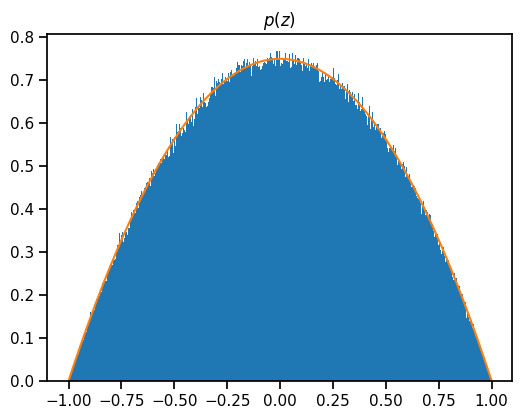

In [3]:
eps_sample = np.random.uniform(size=1000000)
z_sample = 2 * np.cos((np.arccos(1-2*eps_sample) + math.pi) / 3)

p = lambda z: 0.75 * (1-z**2)

z_sample.sort()

with plot_context(show=True, title=r"$p\left(z\right)$"):
    plt.hist(z_sample, bins=500, density=True)
    plt.plot(z_sample, p(z_sample))

## 2. Monte Carlo estimacija očekivanja

U nastavku ćemo koristiti paket `sympy` za simboličko računanje.
Proučite sljedeće funkcije i klase:
  - <a href="https://docs.sympy.org/latest/modules/core.html#sympy.core.symbol.symbols">`symbols`</a> &mdash; za stvaranje simbola,
  - <a href="https://docs.sympy.org/latest/modules/core.html#sympy.core.numbers.Rational">`Rational`</a> &mdash; za definiranje razlomaka, 
  - <a href="https://docs.sympy.org/latest/modules/core.html#sympy.core.basic.Basic.subs">`subs`</a> &mdash; za zamjenu simbola proizvoljnim izrazom,
  - <a href="https://docs.sympy.org/latest/modules/core.html#sympy.core.function.diff">`diff`</a> &mdash; za računanje derivacija,
  - <a href="https://docs.sympy.org/latest/modules/integrals/integrals.html#sympy.integrals.integrals.integrate">`integrate`</a> &mdash; za računanje određenih i neodređenih integrala,
  - <a href="https://docs.sympy.org/latest/modules/solvers/solvers.html#sympy.solvers.solvers.solve">`solve`</a> &mdash; za rješavanje sustava jednadžbi i/ili nejednadžbi, i
  - <a href="https://docs.sympy.org/latest/modules/utilities/lambdify.html#sympy.utilities.lambdify.lambdify">`lambdify`</a> &mdash; za pretvaranje simboličkog izraza u `numpy` ili `tensorflow` funkciju.
 
Osim navedenih, `sympy` sadrži i uobičajene matematičke funkcije kao npr. `cos`, `exp`, `sqrt`, i ostale.
Dokumentaciju možete prikazati i u Jupyter notebooku/JupyterLab-u sa <i>shortcutom</i> `Shift + Tab` za pregled, odnosno `Shift + Tab, Tab` za prikaz cijele dokumentacije.

<b>Zadatak:</b> Simbolički definirajte varijablu $z$ i funkciju gustoće $p\q(z\w) = \frac{3}{4} \q(1 - z^2\w)$ koju ćete koristiti u narednim zadacima.
Ispišite njezinu formulu pomoću priloženog koda.

<b>Napomena:</b> Nije potrebno zadavati da funkcija gustoće bude jednaka $0$ izvan intervala $\q[-1, 1\w]$; umjesto toga samo nećemo koristiti funkciju izvan tog intervala.
Isto vrijedi i za sve ostale simbolički definirane funkcije.

In [4]:
z = sp.symbols("z")

p = 0.75 * (1 - z**2)

display(Math(rf"p\q(z\w) = {sp.latex(p)}"))

<IPython.core.display.Math object>

---

Jednostavan i nepristran <a href="https://www.wikiwand.com/en/Monte_Carlo_method">Monte Carlo</a> estimator očekivanja neke funkcije slučajne varijable $f\q(\e z\w)$ uz gustoću vjerojatnosti $p\q(\e z\w)$ je
\begin{align}
  \mathbb{E}_{\e z \sim p\q(\e z\w)} \q[f\q(\e z\w)\w] 
  &= \int_{\mathcal Z} f\q(\e z\w) p\q(\e z\w) \, d\e z \\
  &\approx \frac{1}{L} \sum_{l=1}^L f\q(\e z^{(l)}\w), \quad \e z^{(l)} \sim p\q(\e z\w),
\end{align}
odnosno, procjenu očekivanja dobijemo tako da $L$ puta uzorkujemo slučajnu varijablu $\e z$, te izračunamo prosječnu vrijednost funkcije $f\q(\e z\w)$ za tih $L$ uzoraka.

Ovaj estimator isprobat ćemo na slučajnom procesu $f\q(z, t\w)$, gdje je $z$ slučajna varijabla, a $t$ vrijeme.
Slučajna varijabla $z$ ima gustoću vjerojatnosti iz prethodnog zadatka, $p\q(z\w) = \frac{3}{4} \q(1 - z^2\w)$.

---

<b>Zadatak:</b> Iskoristite priloženi kod za simboličko definiranje jednog slučajnog procesa koji ćete koristiti u narednim zadacima.
Zatim prikažite na grafu 2-3 realizacije slučajnog procesa $f\q(z, t\w)$ za proizvoljno izabrane realizacije varijable $z$ i za vrijeme $t \in \q[0, 1\w]$.

<b>Napomena:</b> Sam slučajni proces zadaje se slučajno pri svakom pozivu funkcije `gen_f_zt`.

<b>Napomena 1:</b> Ako je realizacija slučajne varijable $z = z_0$, onda je realizacija slučajnog procesa $f\q(z, t\w) = f\q(z_0, t\w)$.

<b>Napomena 2:</b> Za crtanje grafova simbolički izraz najprije moramo pretvoriti u `numpy` funkciju, koristeći funkciju `lambdify` iz paketa `sympy`.

<IPython.core.display.Math object>

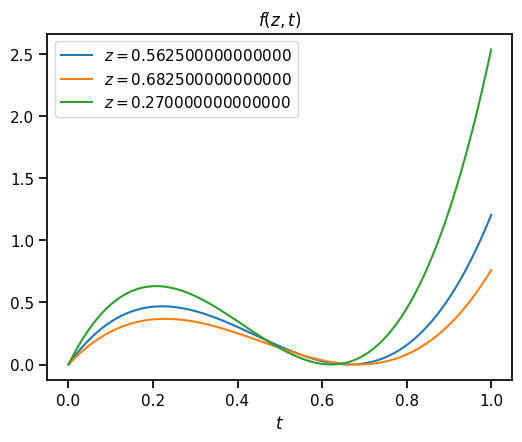

In [5]:
from utils import gen_f_zt

z, t = sp.symbols(["z", "t"])
f = gen_f_zt(z, t)

display(Math(rf"f \q(z, t\w) = {sp.latex(f)}"))

# preporuka: koristiti sufiks `_numpy` u imenu varijable kako se numpy funkcija ne bi miješala sa simboličkim izrazom
f_numpy = sp.lambdify((z, t), f, "numpy")

ts = np.linspace(0.0, 1.0, 101)
zs = [p.subs(z, -0.5), p.subs(z, 0.3), p.subs(z, 0.8)]

with plot_context(show=True, title=r"$f\left(z, t\right)$", xlabel=r"$t$", legend=[rf"$z={zs[i]}$" for i in range(3)]):
    for i in range(3):
        plt.plot(ts, f_numpy(zs[i], ts))

---

Definirajmo funkciju $g\q(t\w)$ kao očekivanje slučajnog procesa $f\q(z, t\w)$:
\begin{equation}
  g\q(t\w) := \mathbb{E}_{z \sim p\q(z\w)} \q[ f\q(z, t\w) \w] = \int_{\mathcal Z} f\q(z, t\w) p\q(z\w) \, dz,
\end{equation}
te njegovu MC estimaciju:
\begin{equation}
  \hat{g}_L^{(\mathit{MC})}\q(t\w) := \frac{1}{L} \sum_{l=1}^L f\q(z^{(l)}, t\w), \quad z^{(l)} \sim p\q(z\w).
\end{equation}

---

<b>Zadatak:</b> Simbolički izračunajte $g\q(t\w)$ i ispišite njezinu formulu pomoću priloženog koda.
Zatim simboličku funkciju `g` pretvorite u `numpy` funkciju `g_numpy` kako biste ju mogli upotrijebiti u idućem zadatku.

In [6]:
g = sp.integrate(f * p, (z, -1, 1))

display(Math(rf"g \q(t\w) = {sp.latex(g)}"))

g_numpy = sp.lambdify(t, g, "numpy")

<IPython.core.display.Math object>

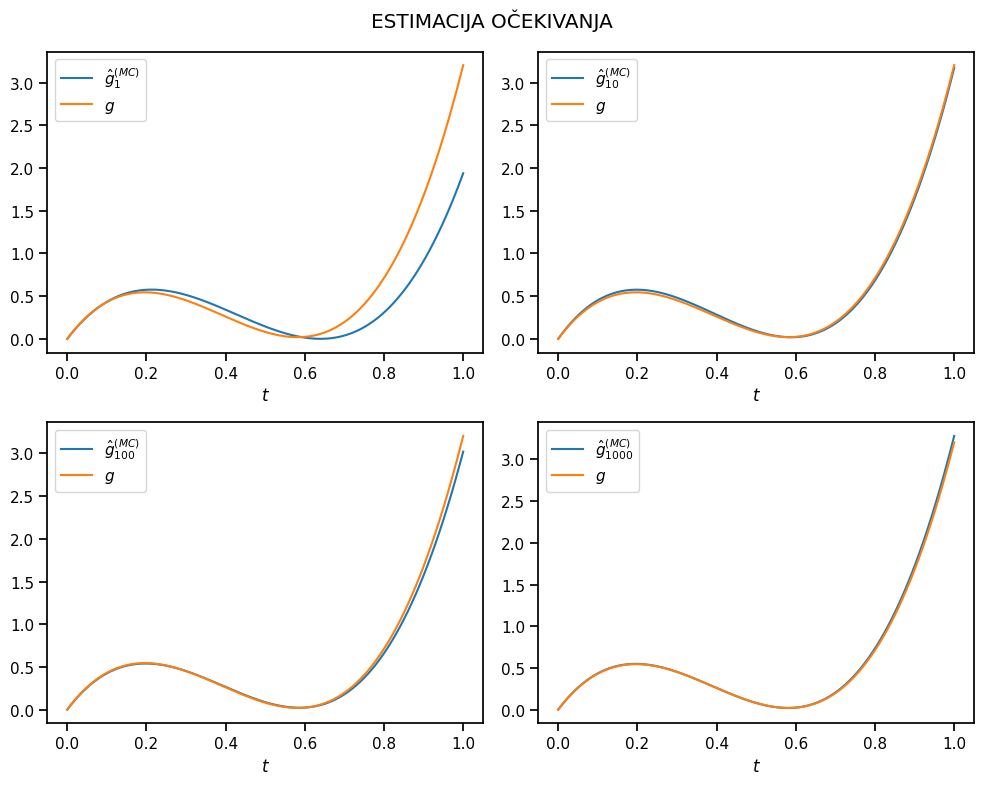

In [7]:
ts = np.linspace(0.0, 1.0, 201)

g_mc = lambda z, t: [np.mean([f_numpy(x, y) for x in z]) for y in t]

sizes = [1, 10, 100, 1000]

with plot_context(figsize=(10, 8), show=True):
    for i, size in enumerate(sizes):
        sample_size = np.linspace(-1.0, 1.0, size)
        g_mc_sample = np.random.choice(z_sample, size)
        
        with plot_context(subplot=(2, 2, i + 1), suptitle="ESTIMACIJA OČEKIVANJA", xlabel=r"$t$",
                          legend=[rf"$\hat{{g}}_{{{size}}}^{{(\mathit{{MC}})}}$", r"$g$"]):
            plt.plot(ts, g_mc(g_mc_sample, ts))  # procjena
            plt.plot(ts, g_numpy(ts))  # analitički

    plt.tight_layout()

---

<b>Zadatak:</b> Za različite veličine uzorka $L \in \q\{1, 10, 100, 1000\w\}$, prikažite na 4 odvojena grafa istovremeno:
  - funkciju $\hat{g}^{(\mathit{MC})}_L\q(t\w)$ dobivenu pomoću Monte Carlo simulacije s $L$ uzoraka, i
  - funkciju $g\q(t\w)$ dobivenu analitički,
  
za $t \in \q[0, 1\w]$.
Vidi <a href="slika_1.png">sliku</a> za referencu.

---

## 3. Uzorkovanje po važnosti u MC estimaciji očekivanja

<a href="https://www.wikiwand.com/en/Importance_sampling">Uzorkovanje po važnosti</a> (engl. <i>importance sampling</i>) odnosi se na način generiranja uzorka koji se koristi u Monte Carlo metodi.
U ovom zadatku pokazat ćemo da se očekivanje $\mathbb E_{z \sim p\q(z\w)} \q[f\q(z\w) \w]$ može "kvalitetnije" estimirati MC estimatorom ako uzorak slučajne varijable $z$ generiramo prema nekoj drugoj distribuciji (uz odgovarajuće izmjene na funkciji čije očekivanje računamo).
Konkretno, originalno očekivanje se može prikazati kao:
\begin{align}
  \mathbb E_{z \sim p\q(z\w)} \q[f\q(z\w) \w] &= \int_{\mathcal Z} f\q(z\w) p\q(z\w) \,dz \\[0.2em]
  &= \int_{\mathcal Z} \frac{f\q(z\w) p\q(z\w)}{q\q(z\w)} \cdot  q\q(z\w) \,dz \\[0.2em]
  &= \mathbb E_{z \sim q\q(z\w)} \q[\frac{f\q(z\w) p\q(z\w)}{q\q(z\w)} \w],
\end{align}
gdje je $q\q(z\w)$ neka proizvoljna distribucija (koju zovemo <b>distribucija uzorkovanja</b>), te je sada MC estimator jednak
\begin{equation}
  \frac{1}{L} \sum_{l=1}^L \frac{f\q(z^{(l)}\w) p\q(z^{(l)} \w)}{q\q(z^{(l)} \w)}, \quad z^{(l)} \sim q\q(z\w).
\end{equation}
Uz pažljiv odabir distribucije $q\q(z\w)$ možemo dobiti "kvalitetniji" estimator.

---

<b>Zadatak:</b> Iskoristite priloženi kod za pronalaženje distribucije uzorkovanja $q\q(z\w)$ koja najbolje odgovara za estimaciju očekivanja slučajnog procesa $f\q(z, t\w)$.
Zatim simbolički izračunajte kumulativnu funkciju distribucije $Q\q(z\w) = \int_{-1}^z q\q(z\w) \, dz$.
Pomoću priloženog koda ispišite formule $q\q(z\w)$ i $Q\q(z\w)$.

<b id="nb1">Napomena:</b> Pri izračunavanju teorijski optimalne distribucije $q\q(z\w)$ funkcija `gen_qz` koristi analitički izračunatu vrijednost očekivanja (vidi <a href="https://www.wikiwand.com/en/Importance_sampling#Application_to_simulation">rezultat</a>).
Ovdje optimalnu distribuciju koristimo samo u svrhu upoznavanja s metodom uzorkovanja po važnosti.
U praktičnim problemima optimalnu $q\q(z\w)$ ne možemo izračunati, jer ne znamo egzaktnu vrijednost očekivanja (zato ga i estimiramo!), ali ju možemo učiti u sklopu modela.
Jednu metodu za učenje $q\q(z\w)$ obradit ćemo u 5. zadatku.

In [8]:
from utils import gen_qz

z, t = sp.symbols(["z", "t"])
q = gen_qz(f, z, t)

Q = sp.integrate(q, (z, -1, z))

display(
    Math(rf"\begin{{align}}"
         rf"  q\q(z\w) &= {sp.latex(q)} \\[1em]"
         rf"  Q\q(z\w) &= {sp.latex(Q)}"
         rf"\end{{align}}"))

<IPython.core.display.Math object>

---

<b>Zadatak:</b> Na istom grafu prikažite funkcije gustoće vjerojatnosti $p\q(z\w)$ i $q\q(z\w)$.

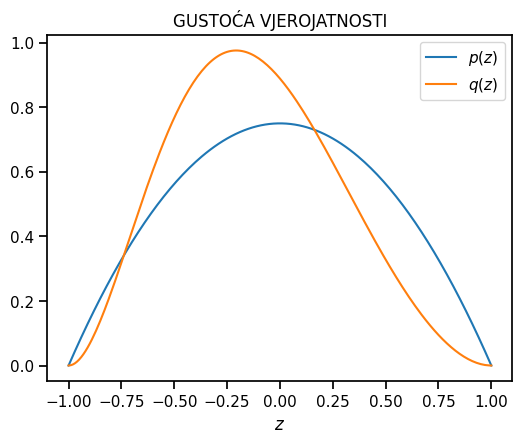

In [9]:
p_numpy = sp.lambdify(z, p, "numpy")
q_numpy = sp.lambdify(z, q, "numpy")

prob_space = np.linspace(-1.0, 1.0, 201)

with plot_context(show=True, title="GUSTOĆA VJEROJATNOSTI", xlabel="$z$",
                  legend=[r"$p\left(z\right)$", r"$q\left(z\right)$"]):
    plt.plot(prob_space, p_numpy(prob_space))  # p(z)
    plt.plot(prob_space, q_numpy(prob_space))  # q(z)

---

Kako bismo mogli generirati uzorak $z \sim q\q(z\w)$, potrebno je opet odrediti inverz kumulativne funkcije distribucije, $Q^{-1}\q(\varepsilon\w)$, no ovaj put inverz <a href="https://www.wikiwand.com/en/Abel-Ruffini_theorem">ne postoji u analitičkom obliku</a>.
Umjesto toga, inverz ćemo odrediti približno pomoću binarnog pretraživanja, odnosno za proizvoljni uzorak $\varepsilon^{(l)} \sim \mathcal U\q(0, 1\w)$ pretraživat ćemo vrijednosti $z$ tako da je $Q\q(z^{(l)}\w) \approx \varepsilon^{(l)}$.

---

<b>Zadatak:</b> Generirajte uzorak slučajne varijable $\varepsilon$ veličine $L = 1000000$ (milijun).
Zatim koristeći priloženu funkciju `gen_inv_cdf` generirajte `numpy` funkciju koja predstavlja inverz kumulativne funkcije distribucije.
Konačno, transformirajte uzorak $\varepsilon$ pomoću generiranog inverza.

Na istom grafu prikažite:
  1. histogram dobivenog uzorka $z \sim q\q(z\w)$, i
  2. funkciju gustoće vjerojatnosti $q\q(z\w)$.
  
Provjerite prati li histogram generiranog uzorka funkciju gustoće vjerojatnosti.

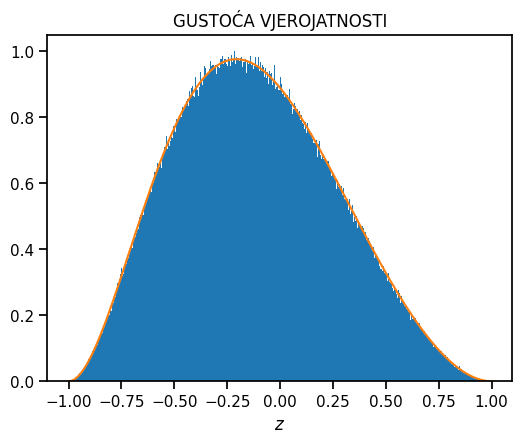

In [10]:
from utils import gen_inv_cdf

Q_numpy = sp.lambdify(z, Q, "numpy")
Q_inv = gen_inv_cdf(Q_numpy)

eps_sample = np.random.uniform(size=1000000)
Q_inv_sample = Q_inv(eps_sample)

z_sample.sort()
Q_inv_sample.sort()


with plot_context(show=True, title="GUSTOĆA VJEROJATNOSTI", xlabel="$z$"):
    plt.hist(Q_inv_sample, bins=500, density=True)
    plt.plot(z_sample, q_numpy(z_sample))


---

<b>Zadatak:</b> Za različite veličine uzorka $L \in \q\{1, 10, 100, 1000\w\}$, prikažite na 4 odvojena grafa istovremeno:
  - funkciju $\hat{g}^{(\mathit{MC})}_L\q(t\w)$ dobivenu pomoću Monte Carlo simulacije s $L$ uzoraka,
  - funkciju $\hat{g}^{(\mathit{ISMC})}_L\q(t\w)$ dobivenu pomoću Monte Carlo simulacije očekivanja uz uzorkovanje po važnosti s $L$ uzoraka, i
  - funkciju $g\q(t\w)$ dobivenu analitički,
  
za $t \in \q[0, 1\w]$.

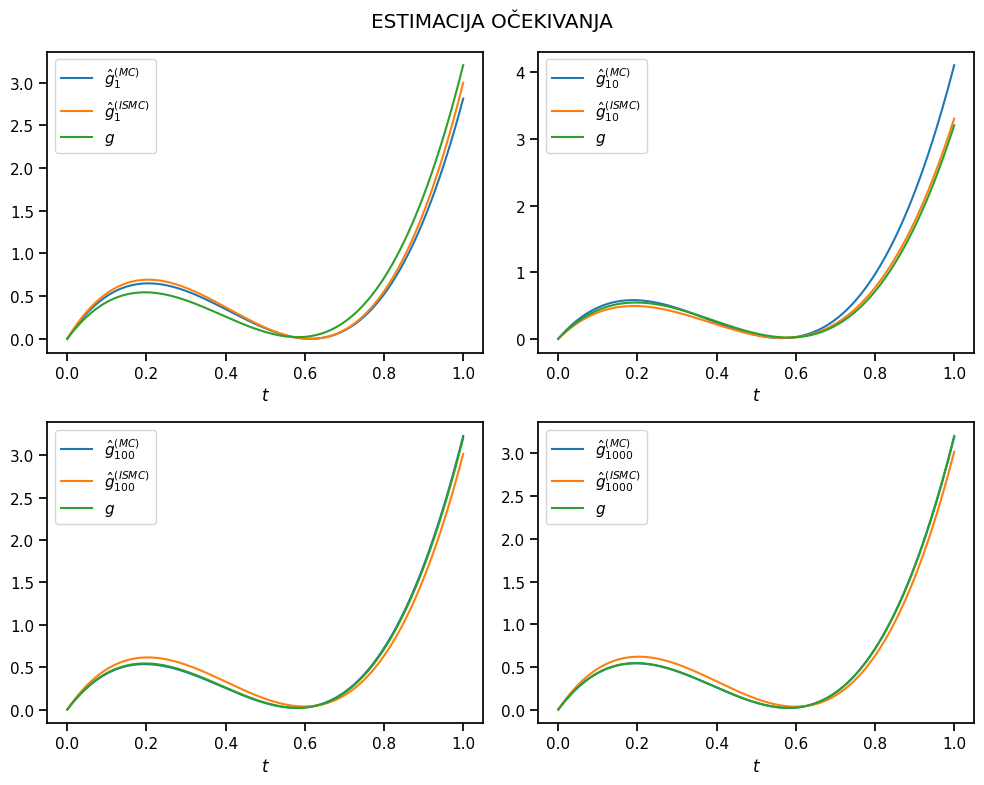

In [11]:
ts = np.linspace(0.0, 1.0, 201)

g_ismc = lambda z, t: [np.mean([f_numpy(x, y)*p_numpy(x)/q_numpy(x) for x in z]) for y in t]

sizes = [1, 10, 100, 1000]

with plot_context(figsize=(10, 8), show=True):
    for i, size in enumerate(sizes):
        sample_size = np.linspace(-1.0, 1.0, size)
        g_mc_sample = np.random.choice(z_sample, size)

        with plot_context(
                subplot=(2, 2, i + 1), suptitle="ESTIMACIJA OČEKIVANJA", xlabel=r"$t$", legend=[
                    rf"$\hat{{g}}_{{{size}}}^{{(\mathit{{MC}})}}$", rf"$\hat{{g}}_{{{size}}}^{{(\mathit{{ISMC}})}}$",
                    r"$g$"
                ]):
            plt.plot(ts, g_mc(g_mc_sample, ts))  # jednostavna estimacija 
            plt.plot(ts, g_ismc(g_mc_sample, ts))  # estimacija uz uzorkovanje po važnosti
            plt.plot(ts, g_numpy(ts))   # analitički

    plt.tight_layout()
    
    


---
Kako bismo mogli izmjeriti razlike u kvaliteti estimatora sa i bez uzorkovanja po važnosti, usporedit ćemo njihove varijance.
Varijancu jednostavnog estimatora možemo procijeniti kao
\begin{align}
  \operatorname{Var}_{z \sim p\q(z\w)} \q[\hat{g}_L^{(\mathit{MC})}\w] = \operatorname{Var}_{z \sim p\q(z\w)} \q[f\q(z, t\w)\w] &= \mathbb E_{z \sim p\q(z\w)} \q[\q(f\q(z, t\w) - g\q(t\w)\w)^2\w] \\[0.2em]
  &\approx \frac{1}{L} \sum_{l=1}^L \q(f\q(z, t\w) - g\q(t\w)\w)^2,
\end{align}
odnosno na sličan način za varijancu estimatora s uzorkovanjem po važnosti.
Primijetite da varijanca definirana na ovaj način ovisi o vremenu $t$.

---
<b>Zadatak:</b>
Za svaki od dva procjenitelja (bez i sa uzorkovanjem po važnosti), prikažite na dva odvojena grafa:
  1. očekivanje procjenitelja (odnosno samu procjenu),
  2. interval povjerenja širine dvije standardne devijacije (očekivanje plus/minus jedna devijacija), i
  3. analitički izračunatu funkciju $g\q(t\w)$.
  
Koristite broj uzoraka $L = 1000$.
Vidi <a href="slika_2.png">sliku</a> za referencu.

<b>Napomena:</b> Pokušajte izbjeći korištenje `for` petlji kod računanja.
Radi veće brzine pokušajte raditi organizirati podatke u matrice oblika $\q[L \times T\w]$ (veličina uzorka $\times$ broj točaka u vremenu) iz kojih usrednjavanjem po prvoj osi (argument `axis=0` kod funkcije `mean`) možete izračunati estimaciju ili varijancu estimatora.
Ako niste sigurni što se dogodi kada radite neku operaciju nad objektima različitih oblika, proučite <a href="https://numpy.org/doc/stable/user/basics.broadcasting.html">mehanizam usklađivanja oblika</a> (engl. <i>broadcasting</i>).
Pritom provjeravajte da su međurezultati očekivanog oblika.
Za slaganje podataka u željeni oblik korisno je poznavati kako rade `numpy` funkcije `reshape`, `transpose`, `squeeze`, `expand_dims`, `concatenate`, `stack`.

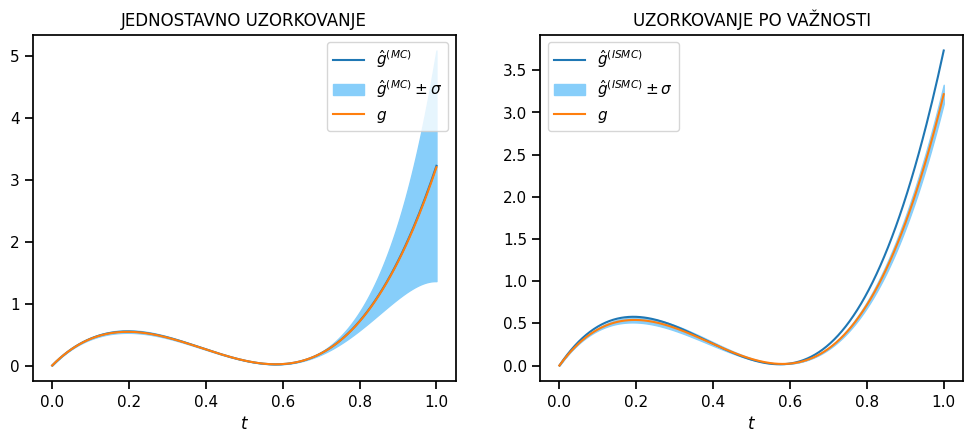

In [12]:
ts = np.linspace(0.0, 1.0, 201)

z_data = np.random.choice(z_sample, 1000)
z_is_data = Q_inv(np.random.choice(eps_sample, 1000))

z_data.sort()
z_is_data.sort()

est_data = np.array(g_mc(z_data, ts))
est_is_data = np.array(g_ismc(z_is_data, ts))

g_stdev = lambda z, mean, t: [np.mean([(f_numpy(x, ts[j]) - mean[j])**2 for x in z]) for j in range(len(t))]
g_ismc_stdev = lambda z, mean, t: [np.mean([(f_numpy(x, t[j])*p_numpy(x)/q_numpy(x) - mean[j])**2 for x in z]) for j in range(len(t))]

stdev_data = np.array(g_stdev(z_data, est_data, ts))
stdev_is_data = np.array(g_ismc_stdev(z_is_data, est_is_data, ts))

with plot_context(figsize=(12, 4.5), show=True):
    with plot_context(subplot=(1, 2, 1), title="JEDNOSTAVNO UZORKOVANJE", xlabel="$t$",
                      legend=[r"$\hat{g}^{(\mathit{MC})}$", r"$\hat{g}^{(\mathit{MC})} \pm \sigma$", r"$g$"]):
        plt.plot(ts, est_data)  # srednja vrijednost
        plt.fill_between(ts, est_data - stdev_data, est_data + stdev_data, color="lightskyblue") # interval povjerenja
        plt.plot(ts, g_numpy(ts))  # analitički

    with plot_context(subplot=(1, 2, 2), title="UZORKOVANJE PO VAŽNOSTI", xlabel="$t$",
                      legend=[r"$\hat{g}^{(\mathit{ISMC})}$", r"$\hat{g}^{(\mathit{ISMC})} \pm \sigma$", r"$g$"]):
        plt.plot(ts, g_numpy(ts))  # srednja vrijednost
        plt.fill_between(ts, est_is_data - stdev_is_data, est_is_data + stdev_is_data, color="lightskyblue")  # interval povjerenja
        plt.plot(ts, g_numpy(ts))  # analitički

---

## 4. Reparametrizacijski trik

U nastavku ćemo razmotriti situaciju kada koristimo neku parametriziranu distribuciju $Q_{\e \phi}$, gdje parametre $\e \phi$ tražimo tako da optimiziraju neki cilj koji se temelji na očekivanju po toj distribuciji:
\begin{equation}
  \operatorname*{arg\, min}_{\e \phi} \q\{ \mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[f\q(z\w) \w]\w\}
\end{equation}
Kada očekivanje <b>ne možemo</b> izračunati analitički, koristimo neki oblik estimacije koji se temelji na izvlačenju slučajnog uzorka $z^{(1)}, z^{(2)}, \ldots, z^{(L)} \sim q_{\e \phi}\q(z\w)$.
Ako bismo optimizaciju htjeli raditi <b>gradijentnim spustom</b>, trebamo bismo moći računati gradijent generiranog uzorka $z^{(l)}$ po parametrima $\e \phi$.
Drugim riječima, potrebno je odgovoriti na pitanje "Kako bi se generirani uzorak $z^{(l)}$ promijenio ako se vrijednost parametara (malo) promijeni?".

Budući da uzorkovanje slučajne varijable nije deterministička operacija, jer je generirani uzorak slučajan, gradijent se također ne može definirati kao deterministička funkcija.
No ako uzorak slučajne varijable iskažemo kao determinističku <b>funkciju parametara</b> njegove distribucije i <b>drugog slučajnog uzorka</b>, tada možemo definirati i gradijent kao determinističku funkciju nad slučajnim uzorkom.
Ovaj postupak se zove <b>reparametrizacijski trik</b>.

Transformacija pomoću inverza kumulativne funkcije distribucije koju smo koristili u ranijim zadacima zapravo je jedna vrsta reparametrizacijskog trika.
U ovom zadatku istu metodu ćemo primijeniti na <a href="https://www.wikiwand.com/en/Exponential_distribution">eksponencijalnu distribuciju</a> $\mathcal E\q(\lambda\w)$ s parametrom $\lambda > 0$.
Gustoća vjerojatnosti je
\begin{equation}
  q_{\e \phi}\q(z\w) = \lambda \exp\q(-\lambda z\w), \quad z \in \q[0, \infty\w>,
\end{equation}
gdje je skup parametara $\e \phi = \q\{ \lambda \w\}$.
Kumulativna funkcija distribucije je 
\begin{equation}
  Q_{\e \phi}\q(z\w) = 1 - \exp\q(-\lambda z\w), \quad z \in \q[0, \infty\w>,
\end{equation}
a njezin inverz može se lako odrediti i jednak je
\begin{equation}
  z = Q^{-1}_{\e \phi}\q(\varepsilon\w) = -\frac{\log\q(1 - \varepsilon\w)}{\lambda}, \quad \varepsilon \in \q[0, 1\w].
\end{equation}
Posljednji izraz opisuje vezu između generiranog uzorka $\varepsilon^{(l)}$, parametra $\lambda$ i uzorka $z^{(l)}$, te možemo računati gradijent
\begin{equation}
  \frac{\partial z^{(l)}}{\partial \lambda} = \frac{\partial}{\partial \lambda} \q(-\frac{\log\q(1 - \varepsilon^{(l)}\w)}{\lambda}\w) = \frac{\log\q(1 - \varepsilon^{(l)}\w)}{\lambda ^2}.
\end{equation}

Gradijent nam daje odgovor na prethodno postavljeno pitanje: ako se parametar $\lambda$ promijeni za neki mali iznos $d\lambda$, tada će se uzorak $z^{(l)}$ promijeniti za 
\begin{equation}
  dz =  \frac{\log\q(1 - \varepsilon^{(l)}\w)}{\lambda^2} \cdot d\lambda
\end{equation}
(podrazumijevajući pritom fiksiran uzorak $\varepsilon^{(l)}$).
Sada je moguće izračunati gradijent parametara $\e \phi$ u MC estimaciji očekivanja uz uzorak $z \sim q_{\e \phi}\q(z\w)$:
\begin{align}
  \frac{\partial}{\partial \e \phi} \mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[f\q(z\w) \w]
  &= \frac{\partial}{\partial \e \phi} \mathbb E_{\varepsilon \sim \mathcal U\q(0, 1\w)} \q[f\q(Q^{-1}\q(\varepsilon\w)\w) \w] \\[0.2em]
  &= \mathbb E_{\varepsilon \sim \mathcal U\q(0, 1\w)} \q[\frac{\partial}{\partial \e \phi} f\q(Q^{-1}\q(\varepsilon\w)\w) \w] \\[0.2em]
  &\approx \frac{1}{L} \sum_{l=1}^L \frac{\partial}{\partial \e \phi} f\q(Q^{-1}\q(\varepsilon^{(l)}\w)\w), \quad \varepsilon^{(l)} \sim \mathcal U\q(0, 1\w)
\end{align}

---

Zadana je funkcija 
\begin{equation}
  f\q(z, a\w) = a \q(1 - \q(1 - \frac{z}{2a}\w)^2\w),
\end{equation}
gdje je $z$ slučajna varijabla s eksponencijalnom distribucijom uz parametar $\lambda$, a $a > 0$ slobodni parametar.

<b>Zadatak:</b> Simbolički definirajte funkciju $f\q(z, a\w)$ i gustoću vjerojatnosti $q\q(z\w)$.
Pomoću priloženog koda ispišite njihove formule.
Prikažite na dva odvojena grafa:
  - funkciju $f\q(z, a\w)$ na intervalu $z \in \q[0, 5\w]$ za vrijednosti parametra $a \in \q\{\frac{1}{2}, 1, 2\w\}$, i
  - gustoću vjerojatnosti $q_{\e \phi}\q(z\w)$ na intervalu $z \in \q[0, 5\w]$ za vrijednosti parametra $\lambda \in \q\{\frac{1}{2}, 1, 2\w\}$.

<p></p>

Razmislite o tome koja gustoća vjerojatnosti na desnom grafu bi <b>maksimizirala</b> očekivanje koje funkcije na lijevom grafu.
U sljedećem zadatku to ćemo provjeriti analitičkim putem, a u zadatku nakon njega učenjem parametra $\lambda$ gradijentnim spustom.

<IPython.core.display.Math object>

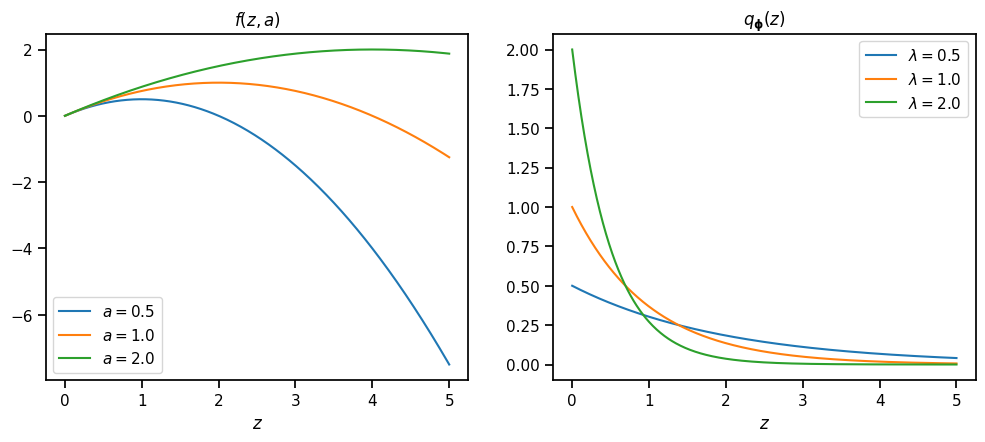

In [13]:
z = sp.symbols("z", nonnegative=True)
a, l = sp.symbols(["a", "lambda"], positive=True)
f = a * (1 - (1 - z/(2*a))**2)
q = l * sp.exp(-l * z)

display(
    Math(rf"\begin{{align}}"
         rf"  f\q(z, a\w) &= {sp.latex(f)}\\[0.2em]"
         rf"  q\q(z\w) &= {sp.latex(q)}"
         rf"\end{{align}}"))

f_numpy = sp.lambdify((z, a), f, "numpy")
q_numpy = sp.lambdify((z, l), q, "numpy")

zs = np.linspace(0.0, 5.0, 501)
as_ = [0.5, 1.0, 2.0]
lambdas = [0.5, 1.0, 2.0]

with plot_context(figsize=(12, 4.5), show=True):
    with plot_context(subplot=(1, 2, 1), title=r"$f\left(z, a\right)$", xlabel="$z$",
                      legend=[rf"$a = {a_}$" for a_ in as_]):
        for a_ in as_:
            plt.plot(zs, f_numpy(zs, a_))
            
    with plot_context(subplot=(1, 2, 2), title=r"$q_{\mathbf{\phi}}\left(z\right)$", xlabel="$z$",
                      legend=[rf"$\lambda = {lambda_}$" for lambda_ in lambdas]):
        for lambda_ in lambdas:
            plt.plot(zs, q_numpy(zs, lambda_))

---

<b>Zadatak:</b> Simboličkim računom odredite vrijednost parametra $\lambda$ uz koju se dostiže <b>maksimum</b> očekivanja,
\begin{equation}
  \lambda^* = \operatorname*{arg\,max}_{\lambda} \mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[f\q(z, a\w)\w].
\end{equation}
Pomoću priloženog koda možete ispisati dobivene vrijednosti međurezultata.

<b>Napomena 1:</b> Najprije izračunajte samo očekivanje $\mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[f\q(z, a\w)\w]$, zatim njegov gradijent po parametru $\lambda$, a zatim riješite jednadžbu 
\begin{equation}
  \frac{\partial}{\partial \lambda} \mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[f\q(z, a\w)\w] = 0
\end{equation}
za parametar $\lambda$.

<b>Napomena 2:</b> Simbol za (pozitivnu) beskonačnost u paketu `sympy` je <a href="https://docs.sympy.org/latest/modules/core.html#sympy.core.numbers.Infinity">`oo`</a> (odnosno `sp.oo`).

In [14]:
E = sp.integrate(f * q, (z, 0, sp.oo))  # očekivanje
dE_dl = sp.diff(E, l)  # derivacija očekivanja po parametru lambda
lambda_opt, = sp.solve(dE_dl, l)  # nultočka derivacije (`solve` vraća listu rješenja!)

display(
    Math(rf"\begin{{align}}"
         rf"  \mathbb E_{{z \sim q_{{\e \phi}}\q(z\w)}} \q[f\q(z, a\w)\w] &= {sp.latex(E.simplify())} \\[0.5em]"
         rf"  \frac{{\partial}}{{\partial \lambda}} \q(\mathbb E_{{z \sim q_{{\e \phi}}\q(z\w)}} \q[f\q(z, a\w)\w]\w)"
         rf"    &= {sp.latex(dE_dl.simplify())} = 0 \\[0.5em]"
         rf"  \lambda^* &= {sp.latex(lambda_opt)}"
         rf"\end{{align}}"))

<IPython.core.display.Math object>

---

<b>Zadatak:</b> Varirajte vrijednost parametra $a$ <b>između 0.5 i 2</b>.
Zatim MC estimatorom uz reparametrizacijski trik i uzorak veličine $L = 1000$ približno izračunajte gornje očekivanje,
\begin{align}
  \varepsilon^{(l)} &\sim \mathcal U\q(0, 1\w), & l &\in \q\{1, 2, \ldots, L\w\} \\[0.2em]
  z^{(l)} &= Q_{\e \phi}^{-1}\q(\varepsilon^{(l)}\w), & \quad l &\in \q\{1, 2, \ldots, L\w\} \\[0.2em]
  \mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[f\q(z, a\w)\w] &\approx \frac{1}{L} \sum_{l=1}^{L} f\q(z^{(l)}, a\w)
\end{align}
te gradijentnim spustom odredite vrijednost parametra $\lambda$ uz koji će očekivanje biti <b>maksimalno</b>.
Zbog ograničenja $\lambda > 0$, umjesto parametra $\lambda$ optimirajte parametar $\log \lambda \in \mathbb R$.
Ispišite naučenu vrijednost parametra $\lambda$ i provjerite odgovara li ona optimalnoj vrijednosti $\lambda^*$ koju ste izveli u prethodnom zadatku.

<b>Napomena 1:</b> <b>minimizirajte</b> negativno očekivanje.

<b>Napomena 2:</b> ne treba ručno računati gradijente.

In [15]:
# budući da ćemo trebati backprop, funkcija mora biti "tensorflow" funkcija
f_tf = sp.lambdify((z, a), f, "tensorflow") # Zadana funkcija: a * (1 - (1 - z/(2*a))**2)
Q_inv = lambda eps, l: -(tf.math.log(1-eps) / l) # za sampliranje z

L = 1000
loglambda = tf.Variable([[0.0]])

optimizer = tf.optimizers.Adam(1e-2)
a_numpy = 1.25  # odabrana vrijednost parametra a


for epoch in range(1000):
    with tf.GradientTape() as tape:
        eps = np.random.uniform(size=[L, 1]).astype(np.float32) # sampliramo eps
        lambda_ = tf.math.exp(loglambda)
        z_sample = Q_inv(eps, lambda_) # sampliramo z preko eps tj inverz Q
        loss = - tf.math.reduce_sum(f_tf(z_sample, a_numpy)) / L # sumiraj gubitke primjeraka kroz tensor i podijeli s brojem primjera

    grad = tape.gradient(loss, loglambda)
    optimizer.apply_gradients([(grad, loglambda)])

lambda_opt_numpy = lambda a: 1 / a

print(f"OPTIMALNO: {lambda_opt_numpy(a_numpy):.5f}")
print(f"NAUČENO:   {lambda_.numpy().squeeze():.5f}")

OPTIMALNO: 0.80000
NAUČENO:   0.81093


---

## 5. Varijacijska inferencija

<a href="https://www.wikiwand.com/en/Variational_Bayesian_methods">Varijacijska inferencija</a> je primjena <a href="https://www.wikiwand.com/en/Calculus_of_variations">računa varijacija</a> kod modela s latentnim varijablama za približno određivanje <b>posteriorne distribucije</b> $p\q(z \cb x\w)$ nekom funkcijom $q_{\e \phi}\q(z \cb x\w)$.
Račun varijacija bavi se optimizacijskim problemima gdje se rješenje traži u obliku funkcije koja mora zadovoljavati određena ograničenja &mdash; u našem slučaju ograničenje je da tražena funkcija mora biti dobro definirana funkcija gustoće vjerojatnosti.

Posteriorna distribucija $p\q(z \cb x\w)$ govori nam kakva je distribucija latentne varijable $z$ uz određenu realizaciju varijable $x$ i definirana je kao
\begin{equation}
  p\q(z \cb x \w) = \frac{p\q(x \cb z\w) p\q(z\w)}{p\q(x\w)}.
\end{equation}
Posteriorna distribucija posebno je zanimljiva zato što predstavlja <b>optimalnu distribuciju uzorkovanja</b> kod uzorkovanja po važnosti:
\begin{align}
  p\q(x\w) &=  \mathbb E_{z \sim p\q(z\w)} \q[ p\q(x \cb z\w) \w] \\[0.5em]
  &= \mathbb E_{z \sim p\q(z \cb x\w)} \q[ \frac{p\q(x \cb z\w) p\q(z\w)}{p\q(z \cb x\w)} \w] \\[0.5em]
  &= \frac{1}{L} \sum_{l=1}^L \frac{p\q(x \cb z^{(l)}\w) p\q(z^{(l)}\w)}{p\q(z^{(l)} \cb x\w)}, \quad z^{(l)} \sim p\q(z \cb x\w) \\[0.5em]
  &= \frac{1}{L} \sum_{l=1}^L p\q(x\w),
\end{align}
gdje vidimo da je izraz unutar znaka sumacije <b>po definiciji jednak</b> traženoj $p\q(x\w)$; pa bismo poznavanjem $p\q(z \cb x\w)$ izravno mogli dobiti i $p\q(x\w)$.
Međutim, za egzaktno određivanje $p\q(z \cb x\w)$ treba poznavati $p\q(x\w)$, što je zapravo distribucija koju želimo naučiti (prisjetite se <a href="#nb1">napomene</a> iz 3. zadatka), stoga pravu posteriornu distribuciju <b>ne možemo</b> koristiti za uzorkovanje po važnosti.
Umjesto toga, korištenjem varijacijske inferencije pronalazimo distribuciju $q_{\e \phi}\q(z \cb x\w)$ koja po određenom kriteriju najbolje aproksimira $p\q(z \cb x \w)$.

Varijacijsku inferenciju istražit ćemo na posebno konstruiranom primjeru gdje je prava posteriorna distribucija (i distribucija podataka) analitički izračunljiva.
U prvom dijelu ćemo se pobliže upoznati s gustoćom vjerojatnosti koja je zadana kao bivarijatni polinom kojeg lako možemo integrirati, pa je stoga pogodna za računanje izvedenih marginalnih, uvjetnih, i kumulativnih distribucija koje su inače kod modela s kontinuiranom latentnom varijablom netraktabilne.
U drugom dijelu ćemo pomoću varijacijske inferencije aproksimirati distribuciju $p\q(z \cb x\w)$ parametriziranom distribucijom $q_{\e \phi}\q(z \cb x \w)$.
Dobiveni rezultat bit će izravno koristan za treniranje varijacijskog autoenkodera u idućem zadatku.

---

<b>Zadatak:</b> Pomoću priloženog koda simbolički definirajte jednu zajedničku gustoću vjerojatnosti $p\q(x, z\w)$ (s pretpostavljenim vrijednostima parametara $M = N = 2$).
Gustoća vjerojatnosti ima oblik
\begin{equation}
  p\q(x, z\w) = \sum_{i=1}^{2M+2} \sum_{j=1}^{2N+2} C_{i,j} x^i z^j, \quad \text{za} \, x \in \q[-1, 1\w], \, z \in \q[-1, 1\w],
\end{equation}
gdje je $\e C$ matrica koeficijenata dimenzija $\q[\q(2M + 2\w) \times \q(2N + 2\w)\w]$ koja je podešena tako da $p\q(x, z\w)$ bude dobro definirana gustoća vjerojatnosti.

Zatim simbolički izračunajte marginalne gustoće vjerojatnosti $p\q(x\w)$ i $p\q(z\w)$.
Ispišite njihove formule pomoću priloženog koda.

<b>Napomena:</b> U svrhu lakšeg razumijevanja same varijacijske inferencije, u ovom zadatku će zadana distribucija $p\q(x, z\w) = p\q(x \cb z\w)p\q(z\w)$ biti <b>fiksirana</b> (nećemo ju učiti).
U sljedećem zadatku, ta distribucija bit će <b>parametrizirana</b> te ćemo i njezine parametre također učiti.

In [ ]:
from utils import gen_p
from printing import MatrixAlignRightPrinter

x, z = sp.symbols(["x", "z"])
p_mat, p = gen_p(x, z)  # p je zajednička gustoća vjerojatnosti p(x, z)
p_x = ...  # marginalna gustoća vjerojatnosti p(x)
p_z = ...  # marginalna gustoća vjerojatnosti p(z)

display(
    Math(rf"\begin{{align}}"
         rf"  p \q(x, z \w) &= {MatrixAlignRightPrinter(settings={'mat_str': 'array'}).doprint(p_mat)} \\[0.5em]"
         rf"  p \q(x \w)    &= {sp.latex(p_x)} \\[0.5em]"
         rf"  p \q(z \w)    &= {sp.latex(p_z)}"
         rf"\end{{align}}"))

del p_mat  # `p_mat` se koristi samo za prikaz formule

---

<b>Zadatak:</b> Pretvorite simboličku gustoću vjerojatnosti `p` u `numpy` funkciju.
Zatim pomoću priloženog koda prikažite gustoću vjerojatnosti $p\q(x, z\w)$ kao <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html">ispunjeni konturni graf</a>.

<b>Napomena:</b> Proučite kako rade funkcije `np.meshgrid` i `plt.contourf`.
Dokumentaciju selektirane funkcije možete prikazati u Jupyter Notebooku/JupyterLab-u shortcutom `Shift + Tab`.

In [ ]:
p_numpy = ...

xx, zz = np.meshgrid(np.linspace(-1.0, 1.0, 201), np.linspace(-1.0, 1.0, 201))

with plot_context(show=True, colorbar=True, xlabel=r"$x$", ylabel=r"$z$", title=r"$p\left(x, z\right)$"):
    plt.contourf(xx, zz, p_numpy(xx, zz), levels=500)

---

<b>Zadatak:</b> Prikažite grafove marginalnih gustoća vjerojatnosti $p\q(x\w)$ i $p\q(z\w)$.

In [ ]:
p_x_numpy = ...
p_z_numpy = ...

ts = np.linspace(-1.0, 1.0, 201)

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title=r"$p\left(x\right)$", xlabel=r"$x$"):
        plt.plot

    with plot_context(subplot=(1, 2, 2), title=r"$p\left(z\right)$", xlabel=r"$z$"):
        plt.plot

---

<b>Zadatak:</b> Simbolički izračunajte kumulativne funkcije distribucije $P\q(z\w)$ i $P\q(x\w)$, te generirajte pripadne `numpy` funkcije.
Za svaku od navedenih distribucija generirajte uzorak veličine $L = 1000000$ (milijun) koristeći metodu transformacije pomoću inverza kumulativne funkcije distribucije.
Prikažite na dva odvojena grafa histogram uzorka i gustoću vjerojatnosti.
Uvjerite se da se uzorak ravna prema distribuciji iz koje je generiran.

<b>Napomena:</b> Inverze kumulativnih funkcija distribucija generirajte pomoću priložene funkcije `gen_inv_cdf`.

In [ ]:
P_z = ...  # kumulativna funkcija distribucije P(z)
P_x = ...  # kumulativna funkcija distribucije P(x)

P_z_numpy = ...
P_x_numpy = ...

P_z_inv_numpy = ...
P_x_inv_numpy = ...

ts = np.linspace(-1.0, 1.0, 201)

L = 1000000

with plot_context(figsize=(12, 4.5), show=True):
    with plot_context(subplot=(1, 2, 1), title=r"$p\left(x\right)$", xlabel=r"$x$"):
        eps = ...
        x_sample = ...
        
        plt.plot
        plt.hist

    with plot_context(subplot=(1, 2, 2), title=r"$p\left(z\right)$", xlabel=r"$z$"):
        eps = ...
        z_sample = ...
        
        plt.plot
        plt.hist

---

<b>Zadatak:</b> Simbolički definirajte uvjetne gustoće vjerojatnosti $p\q(x \cb z\w)$ i $p\q(z \cb x\w)$.
Zatim svaku prikažite na zasebnom ispunjenom konturnom grafu.

<b>Napomena 1:</b> Nije potrebno ispisivati formule uvjetnih gustoća vjerojatnosti.

<b>Napomena 2:</b> Na rubovima grafova može se dogoditi pogreška zbog dijeljenja s nulom, što će se vidjeti kao bijela pruga. 
Razlog tome je što funkcija na rubu poprima neodređeni oblik $\frac{0}{0}$.
Prava vrijednost se može točno izračunati simboličkim računom; no to nije potrebno raditi za ovu vježbu.

In [ ]:
p_xz = ...  # uvjetna gustoća vjerojatnosti p(x|z)
p_zx = ...  # uvjetna gustoća vjerojatnosti p(z|x)

p_xz_numpy = ...
p_zx_numpy = ...

with plot_context(show=True, figsize=(10, 4.5)):
    with plot_context(subplot=(1, 2, 1), colorbar=True, title=r"$p\left(x \,\vert\, z \right)$", xlabel=r"$x$",
                      ylabel=r"$z$"):
        plt.contourf

    with plot_context(subplot=(1, 2, 2), colorbar=True, title=r"$p\left(z \,\vert\, x \right)$", xlabel=r"$z$",
                      ylabel=r"$x$"):
        plt.contourf

    plt.tight_layout()

---

<b>Zadatak:</b> Prikažite na dva odvojena grafa:
 - uvjetnu gustoću vjerojatnosti $p\q(x \cb z\w)$ za realizacije slučajne varijable $z \in \q\{-\frac{1}{2}, 0, \frac{1}{2}\w\}$ (3 krivulje), i
 - uvjetnu gustoću vjerojatnosti $p\q(z \cb x\w)$ za realizacije slučajne varijable $x \in \q\{-\frac{1}{2}, 0, \frac{1}{2}\w\}$ (3 krivulje).

In [ ]:
...

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title=r"$p\left(x \,\vert\, z \right)$", xlabel=r"$x$",
                      legend=[rf"$z={-0.5  + 0.5 * i}$" for i in range(3)]):
        for i in range(3):
            plt.plot

    with plot_context(subplot=(1, 2, 2), title=r"$p\left(z \,\vert\, x \right)$", xlabel=r"$z$",
                      legend=[rf"$x={-0.5  + 0.5 * i}$" for i in range(3)]):
        for i in range(3):
            plt.plot

---

U ovom dijelu konstruirat ćemo prikladnu parametriziranu distribuciju $q_{\e \phi}\q(z \cb x\w)$ čije parametre $\e \phi$ ćemo tražiti tako da aproksimiraju distribuciju $p\q(z \cb x\w)$.
Kako je gustoća vjerojatnosti $p\q(z \cb x\w) = 0$ za $z \not\in \q[-1, 1\w]$, aproksimacija $q_{\e \phi}\q(z \cb x\w)$ će biti bolja ako i za nju vrijedi isto.
Jedan način da to postignemo je da uzmemo neku distribuciju čija gustoća je definirana nad $\mathbb R$, a zatim ga preslikamo nekom monotonom (ili po dijelovima invertibilnom) funkcijom $f\colon \mathbb R \to \q[-1, 1\w]$.
U ovoj vježbi kao polaznu distribuciju koristit ćemo <b>normalnu</b> $\mathcal N\q(\mu, \sigma^2\w)$, a za preslikavanje ćemo odabrati funkciju <b>tangens hiperbolni</b>.
Rezultantnu distribuciju zvat ćemo <b>tangens hiperbolni normalne distribucije</b> i označavati s $\tanh \mathcal N\q(\mu, \sigma^2\w)$.

Počnimo od reparametrizacije normalne distribucije.
Primjenom transformacije pomoću inverza kumulativne funkcije distribucije, dobivamo
\begin{align}
  \varepsilon &\sim \mathcal U\q(0, 1\w) \\[0.2em]
  u &= \mu + \sigma \sqrt{2} \operatorname{erf}^{-1} \q(2 \varepsilon - 1\w) \sim \mathcal N\q(\mu, \sigma^2\w),
\end{align}
no posebno za normalnu distribuciju možemo i izravno primijeniti svojstvo translacije i skaliranja, pa imamo nešto jednostavniji postupak
\begin{align}
  \varepsilon &\sim \mathcal N\q(0, 1\w) \\[0.2em]
  u &= \mu + \sigma \varepsilon \sim \mathcal N\q(\mu, \sigma^2\w).
\end{align}
Sljedeće moramo definirati gustoću vjerojatnosti slučajne varijable <a href="https://www.wikiwand.com/en/Random_variable#Functions_of_random_variables">nakon preslikavanja</a>.
Primijenjeno na funkciju $z = f\q(u\w) = \tanh\q(u\w)$, imamo
\begin{equation}
  p\q(z\w) = \q[\begin{aligned} z &= \tanh\q(u\w) \\ u &= \tanh^{-1}\q(z\w)\end{aligned}\w]
  = \frac{p\q(u\w)}{\q\lvert \frac{d \tanh\q(u\w)}{du} \w\rvert} = \frac{p\q(u\w)}{1 - \tanh^2\q(u\w)}
\end{equation}
odnosno nakon zamjene $u = \tanh^{-1}\q(z\w)$,
\begin{equation}
  \tanh \mathcal N\q(z; \mu, \sigma^2\w) = \frac{\mathcal N\q(\tanh^{-1}\q(z\w); \mu, \sigma^2\w)}{\q(1 - z^2\w)}.
\end{equation}
Izvedimo odmah i gubitak, odnosno negativni logaritam izglednosti:
\begin{equation}
  L\q(z; \mu, \sigma^2\w) = -\log \mathcal N\q(\tanh^{-1}\q(z\w); \mu, \sigma^2\w) + \log\q(1 - z^2\w),
\end{equation}
gdje je $-\log \mathcal N\q(\tanh^{-1}\q(z\w); \mu, \sigma^2\w)$ negativni logaritam izglednosti normalne slučajne varijable koji smo izveli u prethodnoj laboratorijskoj vježbi.

---

<b>Zadatak:</b> Napišite sljedeće metode:
  - `reparameterize_normal` &mdash; iskazuje slučajnu varijablu $u \sim \mathcal N\q(\mu, \sigma^2\w)$ preko slučajne varijable $\varepsilon \sim \mathcal N\q(0, 1\w)$ i parametara $\mu$ i $\log \sigma^2$,
  - `reparameterize_tanh_normal` &mdash; iskazuje slučajnu varijablu $z \sim \tanh \mathcal N\q(\mu, \sigma^2\w)$ preko slučajne varijable $\varepsilon \sim \mathcal N\q(0, 1\w)$ i parametara $\mu$ i $\log \sigma^2$,  
  - `neglog_normal_pdf` &mdash; računa negativan logaritam izglednosti parametara slučajne varijable $u \sim \mathcal N\q(\mu, \sigma^2\w)$, odnosno gubitak
\begin{equation}
  L\q(u; \mu, \sigma^2\w) = -\log \mathcal N\q(u; \mu, \sigma^2\w),
\end{equation}
  - `neglog_tanh_normal_pdf` &mdash; računa negativan logaritam izglednosti parametara slučajne varijable $z \sim \tanh \mathcal N\q(\mu, \sigma^2\w)$, odnosno gubitak
\begin{equation}
  L\q(z; \mu, \sigma^2\w) = -\log \tanh \mathcal N\q(u; \mu, \sigma^2\w)
\end{equation}
  - `normal_pdf` &mdash; računa gustoću vjerojatnosti slučajne varijable $u \sim \mathcal N\q(\mu, \sigma^2\w)$, i
  - `tanh_normal_pdf` &mdash; računa gustoću vjerojatnosti slučajne varijable $z \sim \tanh \mathcal N\q(\mu, \sigma^2\w)$.

<p></p>

<b>Napomena 1:</b> Određene funkcije mogu se pozivati iz drugih funkcija.
Ako uzmemo to u obzir, implementacija svake funkcije ne bi trebala biti duža od 2-3 linije.

<b>Napomena 2:</b> Unutar funkcije nemojte namještati oblik primljenih tenzora, nego pretpostavite da primljeni tenzori međusobno odgovaraju po obliku.
Uzevši u obzir <a href="https://numpy.org/doc/stable/user/basics.broadcasting.html">mehanizam usklađivanja oblika</a>, ista funkcija se može koristiti za više različitih izračuna; npr. možemo izračunati neku gustoću vjerojatnosti vektora podataka $x$ dimenzija $\q[L \times 1\w]$ uz $L$ različitih vrijednosti parametara (također oblika $\q[L \times 1\w]$), ili uvijek uz istu vrijednost (oblika $\q[1\w]$).

In [ ]:
def reparameterize_normal(eps, mean, logvar):
    ...

def reparameterize_tanh_normal(eps, mean, logvar):
    ...

def neglog_normal_pdf(data, mean, logvar):
    ...
    
def neglog_tanh_normal_pdf(data, mean, logvar):
    ...

def normal_pdf(z, mean, logvar):
    ...

def tanh_normal_pdf(z, mean, logvar):
    ...

---

Promotrimo sada u kakvom su odnosu
  - logaritam gustoće vjerojatnosti podataka, $\log p\q(x\w)$,
  - gustoća vjerojatnosti distribucije uzorkovanja $q_{\e \phi}\q(z \cb x\w)$, i
  - gustoća vjerojatnosti posteriorne distribucije $p\q(z \cb x\w)$.

Logaritam gustoće vjerojatnosti podataka može se rastaviti na dva dijela:

\begin{align}
  \log p\q(x\w) &= \mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \log p\q(x\w) \w] \\[0.2em]
  &= \mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \log \q(\frac{p\q(x \cb z\w) p\q(z\w)}{p\q(z \cb x\w)} \cdot \frac{q_{\e \phi}\q(z \cb x\w)}{q_{\e \phi}\q(z \cb x\w)} \w) \w] \\[0.2em]
  &= \underbrace{\mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \log \frac{p\q(x \cb z\w) p\q(z\w)}{q_{\e \phi}\q(z \cb x\w)} \w]}_{=\mathit{ELBO}_{\e \phi}\q(x\w)}
  + \underbrace{\mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \log \frac{q_{\e \phi}\q(z \cb x\w)}{p\q(z \cb x\w)} \w]}_{=D_{\mathit{KL}}\q( q_{\e \phi}\q(z \cb x\w) \,\m\Vert\, p\q(z \cb x\w) \w)} \\[0.2em]
\end{align}

Prvi dio podsjeća na MC estimaciju očekivanja uz uzorkovanje po važnosti, ali sada izraz pod očekivanjem sadrži i logaritamsku funkciju.
Bez logaritma, očekivanje bi bilo jednako:
\begin{equation}
  \mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \frac{p\q(x \cb z\w) p\q(z\w)}{q_{\e \phi}\q(z \cb x\w)} \w]
  = \mathbb E_{z \sim p\q(z\w)} \q[ p\q(x \cb z\w) \w]
  = p\q(x\w),
\end{equation}
pa bismo imali
\begin{equation}
  \log p\q(x\w) = \log \mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \frac{p\q(x \cb z\w) p\q(z\w)}{q_{\e \phi}\q(z \cb x\w)} \w].
\end{equation}
No <b>očekivanje nad funkcijom</b> slučajne varijable i <b>funkcija nad očekivanjem</b> slučajne varijable općenito <a href="https://www.wikiwand.com/en/Jensen_inequality">nisu jednaki</a>.
Specifično, jer je logaritam konkavna funkcija, imamo da je 
\begin{equation}
  \log p\q(x\w) \ge \mathbb E_{z \sim q_{\e \phi}\q(z \cb x\w)} \q[ \log \frac{p\q(x \cb z\w) p\q(z\w)}{q_{\e \phi}\q(z \cb x\w)} \w].
\end{equation}
Stoga se taj izraz naziva <b>donjom granicom dokaza</b> (engl. <i>evidence lower bound</i>, ELBO).
Dokazom (engl. <i>evidence</i>) se u <a href="https://www.wikiwand.com/en/Bayesian_inference#Formal_explanation">Bayesovskom zaključivanju</a> naziva $\log p\q(x\w)$.

Budući da je donja granica dokaza uvijek manja od $\log p\q(x\w)$, slijedi da je drugi dio uvijek pozitivna veličina.
Nju zovemo <b>Kullback-Leibler divergencijom</b> distribucije $q_{\e \phi}\q(z \cb x\w)$ u odnosu na $p\q(z \cb x\w)$ i označavamo kao $D_{\mathit{KL}}\q( q_{\e \phi}\q(z \cb x\w) \,\m\Vert\, p\q(z \cb x\w) \w)$.
Nju ne možemo izravno računati jer ne znamo $p\q(z \cb x\w)$, no možemo se osloniti na sljedeće: budući da lijeva strana jednakosti $\log p\q(x\w)$ ostaje jednaka bez obzira na vrijednost parametara $\e \phi$, slijedi da maksimizacija donje granice dokaza $\mathit{ELBO}_{\e \phi}\q(x\w)$ dovodi do minimizacije $D_{\mathit{KL}}\q( q_{\e \phi}\q(z \cb x\w) \,\m\Vert\, p\q(z \cb x\w) \w)$, odnosno približavanja aproksimativne posteriorne distribucije $q_{\e \phi}\q(z \cb x\w)$ stvarnoj distribuciji $p\q(z \cb x\w)$.

Donju granicu dokaza također moramo estimirati temeljem određenog broja uzoraka $L$ budući da se radi o očekivanju koje ne možemo izračunati analitički:
\begin{equation}
  \mathit{ELBO}_{\e \phi}\q(x\w) \approx \frac{1}{L} \sum_{l=1}^L \log \frac{p\q(x \cb z^{(l)}\w) p\q(z^{(l)}\w)}{q_{\e \phi}\q(z^{(l)} \cb x\w)}, \quad z^{(l)} \sim q\q(z \cb x\w).
\end{equation}
Pritom je uobičajeno za vrijeme treniranja uzeti uzorak veličine $L = 1$.
Iako je to premalen uzorak za dobru estimaciju, taj nedostatak se nadoknađuje velikim brojem epoha u treniranju.
Također, budući da model treniramo nad mini-grupama od nekoliko podataka odjednom, to znači da će ukupna veličina uzorka varijable $z \sim q_{\e \phi}\q(z \cb x\w)$ odgovarati $L$ puta veličini mini-grupe, odnosno točno veličini mini-grupe kada je $L = 1$ (pritom svaki $z$ dolazi iz distribucije s različitim parametrima $\mu$ i $\sigma^2$, jer parametri ovise o podatku $x$).


---

<b>Zadatak:</b> Dovršite kod za maksimizaciju donje granice dokaza.
U svakom prolasku petlje:
  1. Generirajte jedan uzorak podataka $x \sim p\q(x\w)$ veličine 1000 koristeći transformaciju pomoću inverzne kumulativne funkcije distribucije.
  2. Zatim neuronskom mrežom izračunajte parametre $\mu$ i $\log \sigma^2$ aproksimativne posteriorne distribucije $q_{\e \phi}\q(z \cb x\w)$.
  3. Pomoću reparametrizacijskog trika generirajte uzorak varijable $z \sim q_{\e \phi}\q(z \cb x\w)$ <br>
     (za svaki podatak iz mini-grupe uzmite uzorak veličine $L = 1$).
  4. Izračunajte gubitak, odnosno negativnu donju granicu dokaza.

<b>Napomena:</b> Pripazite da <b>minimizirate negativnu</b> donju granicu dokaza.

In [ ]:
import tensorflow.keras as K

model = K.Sequential([
    K.layers.Dense(100, activation="relu"),
    K.layers.Dense(100, activation="relu"),
    K.layers.Dense(2, activation=None)
])

p_tf = ...  # pretvoriti u "tensorflow" funkciju!
P_x_inv = ...  # inverz kumulativne funkcije distribucije P(x)

optimizer = K.optimizers.Adam(1e-3)

for epoch in range(2000):
    eps = np.random.uniform(size=[1000, 1])
    x_sample = ...  # paziti na oblik i pretvoriti u 32-bitni float pomoću `.astype(np.float32)`

    with tf.GradientTape() as tape:
        mean_z, logvar_z = tf.split(model(x_sample), num_or_size_splits=[1, 1], axis=1)
        eps = ...  # paziti na oblik
        z_sample = ...

        loss = ...

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

---

<b>Zadatak:</b> Prikažite na dva odvojena ispunjena konturna grafa:
  - naučenu aproksimaciju posteriorne distribucije, $q_{\e \phi}\q(z \cb x\w)$, i 
  - stvarnu posteriornu distribuciju, $p\q(z \cb x\w)$.
  
<p></p>

<b>Napomena:</b> Za prikaz naučene aproksimacije posteriorne distribucije potrebno je najprije izračunati parametre $\mu$ i $\log \sigma^2$ pomoću neuronske mreže za svaki ulazni podatak $x \in \q[-1, 1\w]$.
Zatim treba za kombinaciju svakog $z \in \q[-1, 1\w]$ i $x \in \q[-1, 1\w]$ izračunati matricu.
Prilagodite oblike vektora vrijednosti slučajne varijable $z$ te parametara $\mu$ i $\log \sigma^2$ prije poziva funkcije za računanje uvjetne gustoće vjerojatnosti $q_{\e \phi}\q(z \cb x\w)$ i oslonite se na <a href="https://numpy.org/doc/stable/user/basics.broadcasting.html">mehanizam usklađivanja oblika</a>.

In [ ]:
...

with plot_context(show=True, figsize=(10, 4.5)):
    with plot_context(subplot=(1, 2, 1), colorbar=True, title=r"$q\left(z \,\vert\, x \right)$", xlabel=r"$z$",
                      ylabel=r"$x$"):
        plt.contourf

    with plot_context(subplot=(1, 2, 2), colorbar=True, title=r"$p\left(z \,\vert\, x \right)$", xlabel=r"$z$",
                      ylabel=r"$x$"):
        plt.contourf

    plt.tight_layout()

---

<b>Zadatak:</b> Prikažite na dva odvojena grafa:
 - naučenu aproksimaciju posteriorne distribucije $q_{\e \phi}\q(x \cb z\w)$ za realizacije slučajne varijable $x \in \q\{-\frac{1}{2}, 0, \frac{1}{2}\w\}$ (3 krivulje), i
 - stvarnu posteriornu distribuciju $p\q(z \cb x\w)$ za realizacije slučajne varijable $x \in \q\{-\frac{1}{2}, 0, \frac{1}{2}\w\}$ (3 krivulje).

In [ ]:
...

with plot_context(show=True, figsize=(12, 4.5)):
    labels = [r"-\frac{1}{2}", r"0", r"\frac{1}{2}"]
    with plot_context(subplot=(1, 2, 1), title=r"$q\left(z \,\vert\, x \right)$", xlabel=r"$z$",
                      legend=[rf"$z={labels[i]}$" for i in range(3)]):
        for i in range(3):
            plt.plot

    with plot_context(subplot=(1, 2, 2), title=r"$p\left(z \,\vert\, x \right)$", xlabel=r"$z$",
                      legend=[rf"$z={labels[i]}$" for i in range(3)]):
        for i in range(3):
            plt.plot

---

<b>Zadatak:</b> Za različite veličine uzorka $L \in \q\{1, 10, 100, 1000\w\}$, prikažite na 4 odvojena grafa istovremeno:
  - gustoću vjerojatnosti podataka procjenjenu pomoću Monte Carlo simulacije s $L$ uzoraka <b>bez korištenja</b> naučene aproksimativne posteriorne distribucije, odnosno
\begin{align}
  p\q(x\w) &= \mathbb E_{z \sim p\q(z\w)} \q[ p\q(x \cb z\w) \w] \\[0.2em]
  &\approx \frac{1}{L} \sum_{l=1}^L p\q(x \cb z^{(l)}\w), \quad z^{(l)} \sim p\q(z\w)
\end{align}
  - gustoću vjerojatnosti podataka $p\q(x\w)$ dobivenu analitički.

In [ ]:
...

with plot_context(figsize=(12, 9), suptitle=r"PROCJENA BEZ $q_{\mathbf{\phi}}\left(z \,\vert\, x\right)$", show=True):
    for i, size in enumerate(sizes):
        with plot_context(subplot=(2, 2, i + 1), xlabel="$x$",
                          legend=[fr"$\hat{{p}}_{{{size}}}\left(x\right)$", r"$p\left(x\right)$"]):
            plt.plot
            plt.plot

---

<b>Zadatak:</b> Za različite veličine uzorka $L \in \q\{1, 10, 100, 1000\w\}$, prikažite na 4 odvojena grafa istovremeno:
  - gustoću vjerojatnosti podataka procjenjenu pomoću Monte Carlo simulacije s $L$ uzoraka <b>uz korištenje</b> naučene aproksimativne posteriorne distribucije, odnosno
\begin{align}
  p\q(x\w) &= \mathbb E_{z \sim q_{\e \phi}\q(z\w)} \q[ \frac{p\q(x \cb z\w) p\q(z\w)}{q_{\e \phi}\q(z \cb x\w)} \w] \\[0.2em]
  &\approx \frac{1}{L} \sum_{l=1}^L \frac{p\q(x \cb z^{(l)}\w) p\q(z^{(l)}\w)}{q_{\e \phi}\q(z^{(l)} \cb x\w)} , \quad z^{(l)} \sim q\q(z \cb x \w)
\end{align}
  - gustoću vjerojatnosti podataka $p\q(x\w)$ dobivenu analitički.

In [ ]:
...

with plot_context(figsize=(12, 9), suptitle=r"PROCJENA UZ $q_{\mathbf{\phi}}\left(z \,\vert\, x\right)$", show=True):
    for i, size in enumerate(sizes):
        with plot_context(subplot=(2, 2, i + 1), xlabel="$x$",
                          legend=[fr"$\hat{{p}}_{{{size}}}\left(x\right)$", r"$p\left(x\right)$"]):
            plt.plot
            plt.plot

---

<b>Zadatak:</b> Za svaki od prethodna dva procjenitelja $p\q(x\w)$ (bez, odnosno sa korištenjem naučene aproksimativne posteriorne distribucije), prikažite na dva odvojena grafa:
  1. očekivanje procjenitelja (odnosno samu procjenu),
  2. interval povjerenja širine dvije standardne devijacije (očekivanje plus/minus jedna devijacija), i
  3. gustoću vjerojatnosti podataka $p\q(x\w)$ dobivenu analitički.
  
Koristite broj uzoraka $L = 1000$.

In [ ]:
...

with plot_context(figsize=(12, 4.5), show=True):
    legend = [r"$\hat{p}\left(x\right)$", r"$\left(\hat{p} \pm \sigma\right)\left(x\right)$", r"$p\left(x\right)$"]

    with plot_context(subplot=(1, 2, 1), title=r"BEZ $q_{\mathbf{\phi}}\left(z \,\vert\, x\right)$", xlabel="$x$",
                      legend=legend):
        plt.plot
        plt.fill_between
        plt.plot

    with plot_context(subplot=(1, 2, 2), title=r"UZ $q_{\mathbf{\phi}}\left(z \,\vert\, x\right)$", xlabel="$x$",
                      legend=legend):
        plt.plot
        plt.fill_between
        plt.plot

---

## 6. Varijacijski autoenkoder

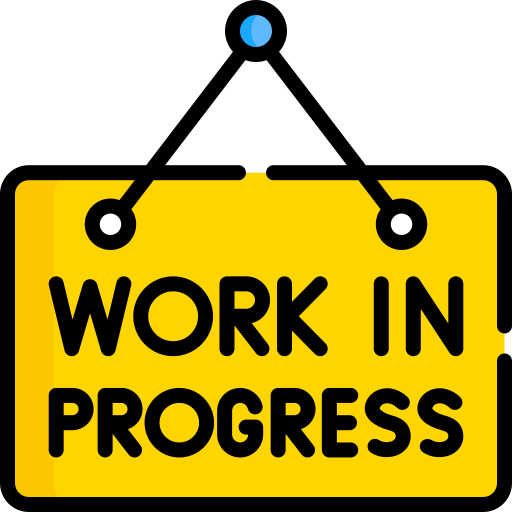

<br>

<i>U akademskoj godini 2022./2023. ovaj zadatak neće biti obavezan dio laboratorijske vježbe, već će biti dostupan u demonstracijskom obliku.</i>